# Discrete control theory / Dynamic programming

## Simple optimal stopping

You are given an urn with $r$ red and $b$ black colored balls. You sequentally pick balls from the urn. If you draw a red ball you win $\$1$, while you lose $\$1$ if the ball is black. Before each draw you must decide whether you want to stop or continue.

What is the fair value of the game, and what is the optimal strategy?


Let $V(r, b)$ be the expected value of the game starting at state with $r$ red and $b$ black balls..

$V(r,b)$ satisfies the recursion

\begin{align}
V(r, b) &= \begin{cases}
0 & \text{if $r=0$ and $b=0$} \\
0 & \text{if $r<0$ and $b<0$} \\
\max(0, f(r,b)) & \text{if $r,b>0$} \\
\end{cases} \\
&= \begin{cases}
0 & \text{if $r=0$} \\
r & \text{if $r>0$ and $b=0$} \\
\max(0, f(r,b)) & \text{if $r,b>0$} \\
\end{cases}
\end{align}
where
\begin{align}
f(r, b) = \frac{r}{r+b} (1 + V(r-1, b)) + \frac{b}{r+b} (-1 + V(r, b-1))),
\end{align}
is the expected value in the next state after continuing by drawing a ball.

The $\max(0, f(r,b))$ is the stopping rule, i.e. we stop if the current value of stopping (zero) is greater than continuing.



In [1]:
import numpy as np

# Lattice method
def optimal_play(r, b):
    def pr_blk(r, b):
        return b / (b + r)

    def pr_red(r, b):
        return r / (b + r)

    cache = np.full((r + 1, b + 1, 2), fill_value=np.nan)
    _STOP, _EITHER, _CONTINUE = 0.0, 0.5, 1.0
    def EV(r, b):
        if ~np.isnan(cache[r, b, 0]):
            return cache[r, b, 0]
        elif r == 0 and b == 0:
            # Empty urn.
            cache[r, b, :] = 0.0, _STOP
            return 0.0
        elif r<0 or b<0:
            # Outside region.
            return 0.0
        else:
            cont_value = pr_red(r, b) * (EV(r-1, b) + 1) + pr_blk(r, b) * (EV(r, b-1) - 1)
            stop_value = 0.0
            opt_value, opt_strat = (cont_value, _CONTINUE) if cont_value > stop_value else (stop_value, _STOP)
            opt_strat = _EITHER if np.isclose(cont_value, stop_value) else opt_strat
            cache[r, b, :] = opt_value, opt_strat
            return opt_value
    value = EV(r, b)
    assert ~np.isnan(cache).any(), ValueError('Missing value in lattice graph.')
    return value, cache
    
r, b = (26, 26)
ev, strat = optimal_play(r, b)
print( 'EV(r,b) = EV({},{}) = {}'.format(r, b, round(ev, 3)) )

EV(r,b) = EV(26,26) = 2.624


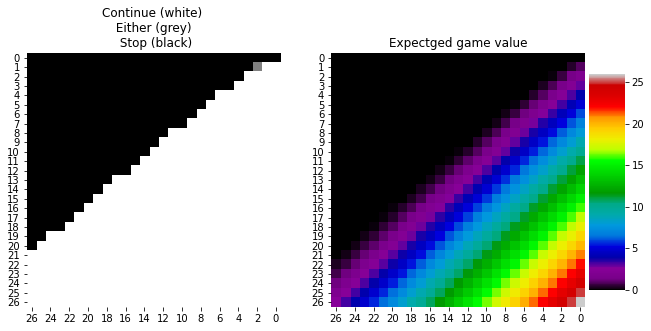

In [2]:
import seaborn as sns
from matplotlib import colors, pyplot as plt

cmap_stopping = colors.ListedColormap(['black', 'grey', 'white'])
fig, axs = plt.subplots(1, 2, figsize=(10,10))
g1 = sns.heatmap(strat[:,:,1], linecolor='k', cbar=False, square=True, cmap=cmap_stopping, ax=axs[0])
g1.invert_xaxis()
g1.set_title('Continue (white) \n Either (grey) \n Stop (black)')

cbar_ax = fig.add_axes([.905, .35, .05, .3])
# cmap= 'Greys' for printing else 'nipy_spectral'
g2 = sns.heatmap(strat[:,:,0], linewidth=0.00, linecolor='k', cbar=True, cbar_ax = cbar_ax, square=True, cmap='nipy_spectral', ax=axs[1])
g2.invert_xaxis()
g2.set_title('Expected game value')
plt.show()

## Simple optimal stopping with single payout on stopping

Draw balls from urn. You can only guess once whether the next ball is red. If you are correct you win $\$1$ and game ends, else game ends and you win nothing.

\begin{align}
V(r, b) &= \begin{cases}
0 & \text{if $r=0$} \\
1 & \text{if $r>0$ and $b=0$} \\
\max\left(\frac{r}{r+b}, f(r,b)\right) & \text{if $r,b>0$} \\
\end{cases}
\end{align}

where
\begin{align}
f(r, b) = \frac{r}{r+b} V(r-1, b) + \frac{b}{r+b} V(r, b-1),
\end{align}
is the expected value given that we continue and do not call out the a red card.

The $\max(0, f(r,b))$ is the stopping rule, i.e. we call out a red card if the expected payoff from calling out a red card is greater than continuing.

**NB**: in case of equal number of red and black balls, the probability is 1/2. It's a consequence of the Optional Stopping Theorem. The percent of cards that are left in the deck in the future, standing at time zero is a martingale. Choosing when to stop and guess red is a stopping time. The expected value of a martingale at a stopping time is equal to the initial value, which is 1/2.



In [3]:
def optimal_play(r, b):
    def pr_blk(r, b):
        return b / (b + r)

    def pr_red(r, b):
        return r / (b + r)

    cache = np.full((r + 1, b + 1, 2), fill_value=np.nan)
    _STOP, _EITHER, _CONTINUE = 0.0, 0.5, 1.0
    def EV(r, b):
        if ~np.isnan(cache[r, b, 0]):
            return cache[r, b, 0]
        elif r == 0 and b == 0:
            # Empty urn.
            cache[r, b, :] = 0.0, _STOP
            return 0.0
        elif r<0 or b<0:
            # Outside region.
            return 0.0
        else:
            cont_value = pr_red(r, b) * EV(r-1, b) + pr_blk(r, b) * EV(r, b-1)
            stop_value = pr_red(r, b)
            opt_value, opt_strat = (cont_value, _CONTINUE) if cont_value > stop_value else (stop_value, _STOP)
            opt_strat = _EITHER if np.isclose(cont_value, stop_value) else opt_strat
            cache[r, b, :] = opt_value, opt_strat
            return opt_value
        
    return EV(r, b), cache
    
r, b = (26, 26)
ev, strat = optimal_play(r, b)
print( 'EV(r,b) = EV({},{}) = {}'.format(r, b, round(ev, 3)) )
#print(strat)

EV(r,b) = EV(26,26) = 0.5


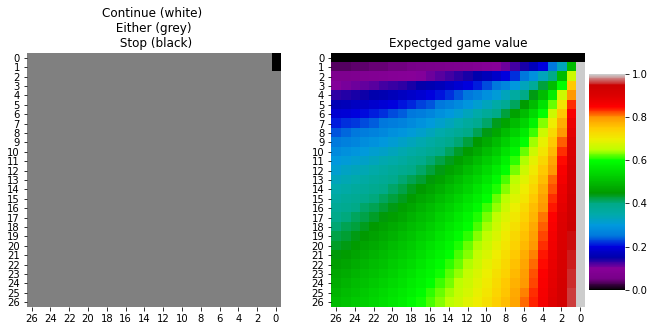

In [4]:
import seaborn as sns
from matplotlib import colors, pyplot as plt


opt_action = strat[:, :, 1]
cmap_stopping = colors.ListedColormap(['black', 'grey', 'white'])
fig, axs = plt.subplots(1, 2, figsize=(10,10))
g1 = sns.heatmap(opt_action, linecolor='k', cbar=False, square=True, cmap=cmap_stopping, ax=axs[0], vmin=0, vmax=1)
g1.invert_xaxis()
g1.set_title('Continue (white) \n Either (grey) \n Stop (black)')


opt_value = strat[:, :, 0]
cbar_ax = fig.add_axes([.905, .35, .05, .3])
# cmap= 'Greys' for printing else 'nipy_spectral'
g2 = sns.heatmap(opt_value, linewidth=0.00, linecolor='k', cbar=True, cbar_ax = cbar_ax, square=True, cmap='nipy_spectral', ax=axs[1])
g2.invert_xaxis()
g2.set_title('Expectged game value')
plt.show()

## Optimal stopping with control variable

You are given an urn with $r$ red and $b$ black colored balls and initial wealth $w$. You sequentally pick balls from the urn until it is empty. Before each ball is picked, you choose to make a bet $0 \leq x \leq w$ on whether the ball is going to be red or black. If you win, you make $x$ and if you incorrect, you lose $x$.

If you want to maximize the expected terminal wealth, what is the optimal strategy?


Let $V(r, b, w; \pi)$ be the expected value of the game starting at state with $r$ red and $b$ black balls, and wealth $w$. Apart from deciding whether to bet red or black, we must decide what fraction $u$ of current wealth to bet, $0\leq u \leq w$.

\begin{align}
V(r, b) &= \begin{cases}
0 & \text{if $r=0$} \\
1 & \text{if $r>0$ and $b=0$} \\
\max\left\{\max_u f_r(r-1,b,w;u), \max_u f_b(r,b-1,w;u) \right\} & \text{if $r,b>0$} \\
\end{cases}
\end{align}

where
\begin{align}
f_r(r, b, w; u) &= \frac{r}{r+b} V(r-1, b, (1 + u)w) + \frac{b}{r+b} V(r, b-1, (1-u)w), \\
f_b(r, b, w; u) &= \frac{r}{r+b} V(r-1, b, (1 - u)w) + \frac{b}{r+b} V(r, b-1, (1+u)w).
\end{align}

That is, $f_r$ is the expected value if we bet $u$ of our wealth on red, and $f_b$ is the expected value if we bet $u$ of our wealth on black.

For convenience, we incorporate the decision to bet on color into the bet size by equating a negative fraction a bet on black, hence $-w \leq u \leq w$. This allows us to define $f(r, b, w; u) := f_r(r, b, w; u)$ such that  $f(r, b, w; -u) \equiv f_b(r, b, w; u)$. We can now write the recursion as

\begin{align}
V(r, b) &= \begin{cases}
0 & \text{if $r=0$} \\
1 & \text{if $r>0$ and $b=0$} \\
\max\left\{\max_{u\geq 0} f(r,b,w;u), \max_{u\geq 0} f(r,b,w;-u) \right\} & \text{if $r,b>0$} \\
\end{cases} \\
&= \begin{cases}
0 & \text{if $r=0$} \\
1 & \text{if $r>0$ and $b=0$} \\
\max_{0 \leq u \leq 1} f(r,b,w;u) & \text{if $r,b>0$} \\
\end{cases}
\end{align}

where
\begin{align}
f(r, b, w; u) &= \frac{r}{r+b} V(r-1, b, (1 + u)w) + \frac{b}{r+b} V(r, b-1, (1-u)w).
\end{align}

In [5]:
import numpy as np
from scipy.optimize import minimize

def optimal_play(r, b, wealth):
    
    def pr_blk(r, b):
        return b / (b + r)

    def pr_red(r, b):
        return r / (b + r)

    def E_bet_red(u, wealth, r, b):
        u = u[0]
        return pr_red(r, b) * EV(r-1, b, wealth * (1 + u)) + pr_blk(r, b) * EV(r, b-1, wealth * (1 - u))
    
    def E_bet_blk(u, wealth, r, b):
        u = u[0]
        return pr_red(r, b) * EV(r-1, b, wealth * (1 - u)) + pr_blk(r, b) * EV(r, b-1, wealth * (1 + u))

    def max_u(func, r, b, wealth):
        bnds = [(0, 1)]
        nfunc = lambda u : -func(u, wealth, r, b)
        res = minimize(nfunc, x0=0.0, bounds=bnds)
        return {'val': -res.fun, 'u': res.x[0]}
    
    cache = np.full((r + 1, b + 1, 2), fill_value=np.nan)
    _BLK, _RED = -1.0, 1.0
    def EV(r, b, wealth):
        if ~np.isnan(cache[r, b, 0]):
            return cache[r,b,0] * wealth
        elif r==0 and b==0:
            cache[r,b, :] = wealth / wealth, 0.0
            return wealth
        elif r<0 or b<0:
            return 0.0
        else:
            best_red = max_u(E_bet_red, r, b, wealth)
            best_blk = max_u(E_bet_blk, r, b, wealth)
            opt_value, opt_color = (best_red, _RED) if best_red['val'] > best_blk['val'] else (best_blk, _BLK)
            cache[r, b, :] = opt_value['val'] / wealth, opt_value['u']*opt_color
            return opt_value['val']
    return EV(r, b, wealth), cache


r, b, w = (26, 26, 1.0)
ev, strat = optimal_play(r, b, w)
print( 'EV(r,b,w) = EV({},{},{}) = {}'.format(r, b, w, round(ev, 3)) )

EV(r,b,w) = EV(26,26,1.0) = 9.081


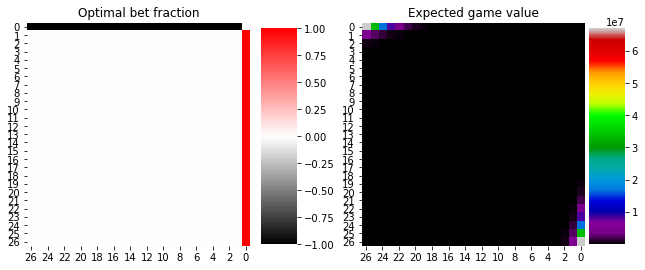

In [6]:
import seaborn as sns
from matplotlib import colors, pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(10,10))



cmap_linseg = colors.LinearSegmentedColormap.from_list("", ['black', 'white', 'red'])
#cmap_linseg = colors.ListedColormap(['black', 'white', 'red'])
opt_bet = strat[:, :, 1]
cbar_ax = fig.add_axes([.450, .35, .05, .3])
g2 = sns.heatmap(opt_bet, linewidth=0.00, linecolor='k', cbar=True, cbar_ax = cbar_ax, square=True, cmap=cmap_linseg, ax=axs[0])
g2.invert_xaxis()
g2.set_title('Optimal bet fraction')

opt_value = strat[:, :, 0]
cbar_ax = fig.add_axes([.905, .35, .05, .3])
# cmap= 'Greys' for printing else 'nipy_spectral'
g3 = sns.heatmap(opt_value, linewidth=0.00, linecolor='k', cbar=True, cbar_ax = cbar_ax, square=True, cmap='nipy_spectral', ax=axs[1])
g3.invert_xaxis()
g3.set_title('Expected game value')


plt.subplots_adjust(wspace=0.5) 
plt.show()